In [1]:
import ndjson
import os
import random
import re
import math
import matplotlib.pyplot as plt

In [2]:
def load_julia_dataset():
    ds = []
    dir = os.path.join("stack-code", "julia")
    files = sorted(os.listdir(dir))
    for f in files:
        f = os.path.join(dir, f)
        print(f"Loading: {f}.")
        with open(f) as f:
            ds += ndjson.load(f)
    return ds

DATASET = load_julia_dataset()
print("Number of files: ", len(DATASET))

Loading: stack-code/julia/0000000.jsonl.
Loading: stack-code/julia/0000001.jsonl.
Loading: stack-code/julia/0000002.jsonl.
Loading: stack-code/julia/0000003.jsonl.
Number of files:  332174


In [10]:
def example_str(ex):
    """
    A rendering of a data sample as a single Julia string.
    """
    return "\n\n".join([
        "# " + ex["max_stars_repo_name"],
        "# " + ex["max_stars_repo_path"],
        ex["content"]])

def filtered(filter):
    return [d for d in DATASET if filter(d)]

def sorted_by_size(ds):
    return sorted(ds, key=lambda x: x["size"], reverse=True)

def save_examples(examples, dir, max_num=None):
    dir = os.path.join("julia-examples", dir)
    os.makedirs(dir, exist_ok=True)
    for i, d in enumerate(examples):
        print(example_str(d), file=open(os.path.join(dir, f"{i}.jl"), "w"))
        if max_num is not None and i >= max_num:
            break

def total_size(ds):
    return sum(d["size"] for d in ds) / 1e9

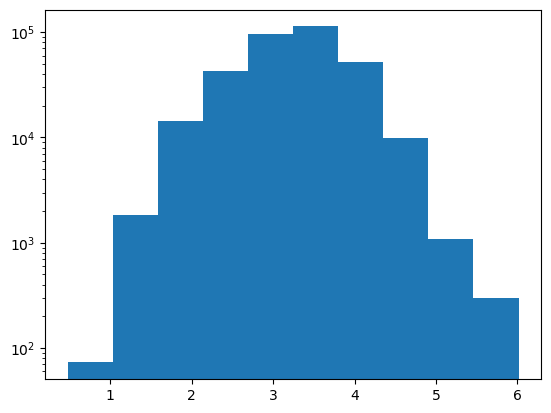

In [4]:
plt.hist([math.log10(d["size"]) for d in DATASET], log=True)
plt.show()

In [5]:
def julia_test_file(ex, ratio=0.1):
    # Whether a file has some minimum ratio of @test statements
    txt = ex["content"]
    kwd = "@test"
    nlines = txt.count("\n") + 1
    return kwd in txt and (txt.count(kwd) / nlines >= ratio)

def julia_numerical_density(ex):
    # The ratio of digit characters over non-digit characters in the file
    txt = ex["content"]
    ntoks = sum(txt.count(c) for c in "0123456789")
    return ntoks / len(txt)

def generated_file(ex):
    #This heuristic happens to be superfluous
    return "generated" in ex["max_stars_repo_name"] or ex["max_stars_repo_name"][0] == "."

def julia_filter(ex):
    if ex["content"][0] in ["%", "{", "["]:
        # Eliminates non-Julia files such as JSON lines (.jl) files 
        return False
    elif ex["size"] >= 1e5:
        # Overly large files are often auto-generated boilerplate and/or mostly
        # contain large arrays of numbers.Thus, we reject such large files unless
        # unless they are test files with low numerical density.
        return julia_test_file(ex) and julia_numerical_density(ex) <= 0.5
    else:
        return True

In [6]:
# A list of keywords that make a Julia file interesting
julia_whitelist = [
    # Popular packages for scientific computing
    "LinearAlgebra",
    "DifferentialEquations",
    "Symbolics",
    "Distributions",
    "DataFrames",
    "DynamicalSystems",
    "Turing",
    "Gen",
    "JuMP",
    # Standard mathematical functions
    "sqrt",
    "abs",
    "zeros",
    "ones",
    "sin",
    "cos",
    "tan",
    "log",
    "exp",
    "integrate",
    "likelihood",
    "Matrix",
    "π",
    "pi",
    "rand",
    "grad"
]

julia_whitelist_rexp = re.compile("|".join("(\\W" + kwd + "\\W)" for kwd in julia_whitelist))

def julia_filter_strict(ex):
    return julia_filter(ex) and julia_whitelist_rexp.search(ex["content"])

In [8]:
# Computing the strict filtered dataset is a bit slow
# This should take about 5-10 minutes.

DATASET_FILTERED = filtered(julia_filter)
DATASET_FILTERED_STRICT = filtered(julia_filter_strict)

print(f"Total: {total_size(DATASET):.2f}GB")
print(f"Filtered: {total_size(DATASET_FILTERED):.2f}GB")
print(f"Filtered strict: {total_size(DATASET_FILTERED_STRICT):.2f}GB")

Total: 1.75GB
Filtered: 1.50GB
Filtered strict: 1.03GB


In [11]:
def save_filtered_examples():
    dataset_shuffled = DATASET_FILTERED.copy()
    random.shuffle(dataset_shuffled)
    dataset_sorted = sorted_by_size(DATASET_FILTERED)
    save_examples(dataset_shuffled, "shuffled", max_num=100)
    save_examples(dataset_sorted, "largest", max_num=100)
    save_examples(DATASET_FILTERED_STRICT, "strict", max_num=100)

save_filtered_examples()